#This notebook includes:







✔ Clean data loading from Google Drive

✔ Train/Val/Test split

✔ Class distribution check

✔ Strong data augmentation

✔ Pretrained EfficientNetB0 model

✔ Callbacks (EarlyStopping, ReduceLROnPlateau, Checkpoint)

✔ Learning curves

✔ Evaluation (classification report + confusion matrix)

✔ Saving model



In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Set Paths & Basic Config

In [2]:
# Set dataset directory (CHANGE THIS to your folder path)
DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/Data'

# Standard Image Settings
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
EPOCHS = 30


Load Dataset + Train/Val/Test Split

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Test set (10% split from validation)
test_ds = val_ds.take(int(len(val_ds) * 0.5))
val_ds = val_ds.skip(int(len(val_ds) * 0.5))

class_names = train_ds.class_names
print("Classes:", class_names)


Found 5287 files belonging to 7 classes.
Using 4230 files for training.
Found 5287 files belonging to 7 classes.
Using 1057 files for validation.
Classes: ['Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus']


# *Check Class Distribution*

---



In [4]:
import numpy as np

y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
unique, counts = np.unique(y_train, return_counts=True)

print("Class distribution:")
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")



Class distribution:
Maize fall armyworm: 236
Maize grasshoper: 547
Maize healthy: 164
Maize leaf beetle: 750
Maize leaf blight: 782
Maize leaf spot: 979
Maize streak virus: 772


# **Prefetching & Performance Optimization**

---



In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(500).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)




---

# **Data Augmentation**

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.25),
    keras.layers.RandomBrightness(0.2),
])


In [7]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False   # Freeze for transfer learning

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# **Compile Model**

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# **Callbacks**

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        "maizemodel.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]


# **Train Model**

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5228 - loss: 1.2413 - val_accuracy: 0.7719 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.7699 - loss: 0.6327 - val_accuracy: 0.7875 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.7889 - loss: 0.5585 - val_accuracy: 0.8246 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.8093 - loss: 0.5046 - val_accuracy: 0.8012 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.8028 - loss: 0.5037 - val_accuracy: 0.8285 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.7939 - loss: 0.5076 - val_accuracy: 0.8304 - val_loss: 0.4707 - learning_rate: 0.0010
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.806

# **Plot Learning Curves**

---



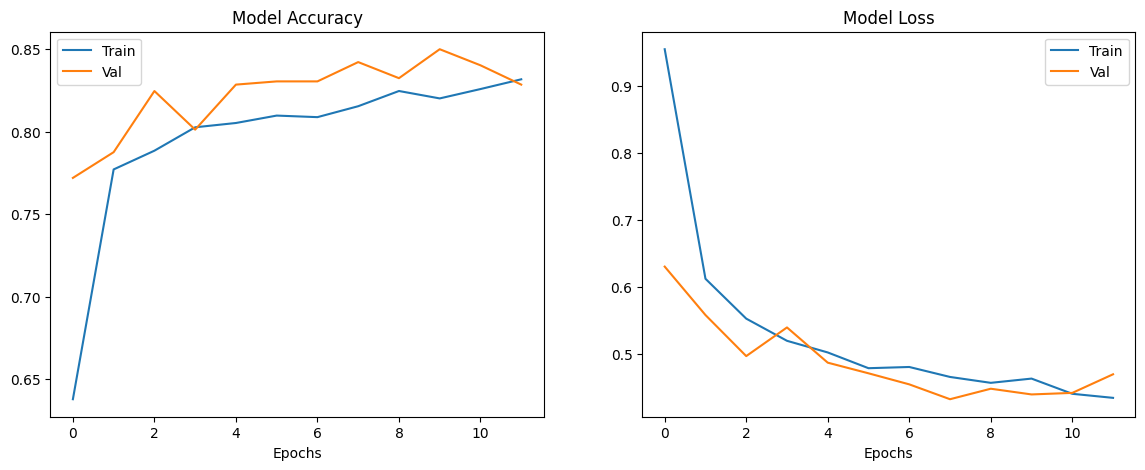

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"])

plt.show()


# **Evaluate on test set**

---



---



In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.8470 - loss: 0.4094
Test Accuracy: 0.84375


# **Confusion Matrix & Classification Report**

---



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
                     precision    recall  f1-score   support

Maize fall armyworm       0.81      0.92      0.86        24
   Maize grasshoper       1.00      0.96      0.98        70
      Maize healthy       0.75      0.94      0.83        16
  Maize leaf beetle       0.96      0.97      0.96        95
  Maize leaf blight       0.85    

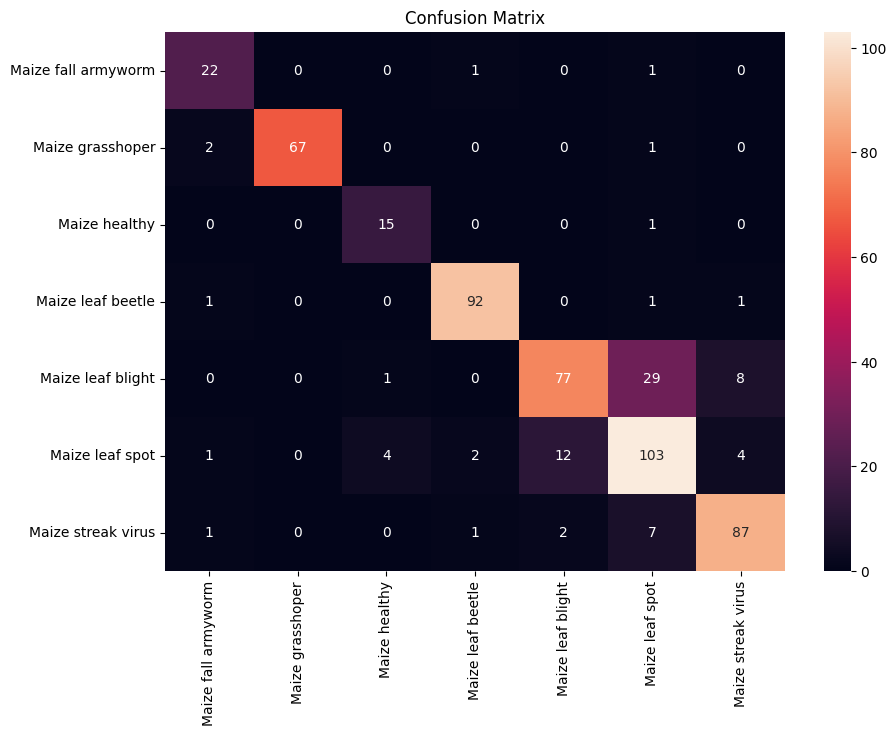

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()


In [14]:
model.save("maize_finalV1.keras")
print("Model saved.")


Model saved.


In [15]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]  # quantization
# tflite_model = converter.convert()

# with open("maize_model.tflite", "wb") as f:
#     f.write(tflite_model)

# print("TFLite model created.")




---

# Code to test the Model

In [16]:
import os
os.listdir()


['.config',
 'grasshopper_test1.jpg',
 'drive',
 'maize_finalV1.keras',
 'maizemodel.keras',
 'sample_data']

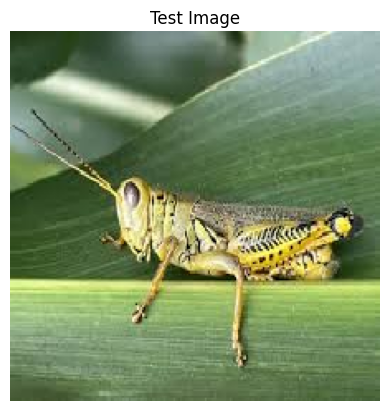

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Maize leaf beetle
Confidence: 0.3525


In [17]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load your saved model
# -------------------------------
model = keras.models.load_model('/content/maize_finalV1.keras')
class_names = ['Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus']

# -------------------------------
# 3. Load and preprocess image
# -------------------------------
img_path = "/content/grasshopper_test1.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # SAME SIZE AS TRAINING
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# -------------------------------
# 4. Show the image
# -------------------------------
plt.imshow(img)
plt.title("Test Image")
plt.axis("off")
plt.show()

# -------------------------------
# 5. Predict
# -------------------------------
pred = model.predict(img_array)
pred_class_index = np.argmax(pred)
pred_class = class_names[pred_class_index]
confidence = np.max(pred)

print("=====================================")
print(f"Predicted class: {pred_class}")
print(f"Confidence: {confidence:.4f}")
print("=====================================")
